In [10]:
from my_sde import *
from models import *
from my_utils import PixelSampler, MyDataset, add_noise

from torch.utils.data import DataLoader

import seaborn as sns
import os

In [11]:
# Training
n_epochs = 3000
batch_size = 512
ema_decay = 0.95
learning_rate = 2.0e-4
n_nodes = 14

beta_min = 0.001
beta_max = 0.5

# Sample
num_nodes = n_nodes
num_epochs = n_epochs
beta_min_ = beta_min
beta_max_ = beta_max

n_samples = 500
num_steps = 5000

Model = MLP_c
n_std = 0.1
n_lim = 0.2

NN_amp = 5

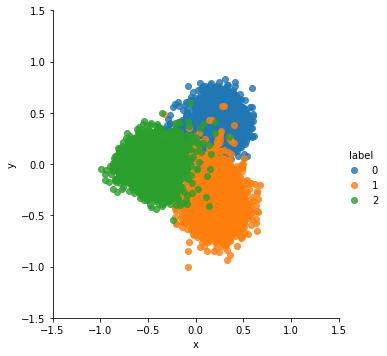

In [12]:
data_df = pd.read_csv('HKU_raw.csv')
data_df[['x', 'y']] = data_df[['x', 'y']]/8
data_df[['x', 'y']] = data_df[['y', 'x']]
sns.lmplot(x='x', y='y', hue='label', data=data_df.groupby('label').head(5000), fit_reg=False, legend=True)
lim = 1.5
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
num = 1

## Training

In [7]:
dataset = MyDataset(torch.tensor(data_df[['x', 'y']].values, dtype=torch.float32).to(device), 
                    torch.tensor(data_df[['label']].values).to(device))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
# training
Model = MLP_c
score_model = Model(n_node=n_nodes, 
                    n_std=n_std, n_lim=n_lim, 
                    amp=NN_amp).to(device)

sde = VPSDE(score_model, beta_min=beta_min, beta_max=beta_max)

alpha = 3e-6
lambda_ = 1e-4
loss_ls = sde.train(dataloader, n_epochs, lr=learning_rate, ema=ema_decay, alpha=alpha, lambda_=lambda_)

Loss: 0.464: 100%|██████████| 3000/3000 [17:33<00:00,  2.85it/s]


In [59]:
# saving model
model_name = f'conditional_{n_nodes}_{n_std}_{n_lim}_{alpha}_{lambda_}_{NN_amp}'

torch.save(score_model.state_dict(), f'score_model/model/{model_name}.pth')

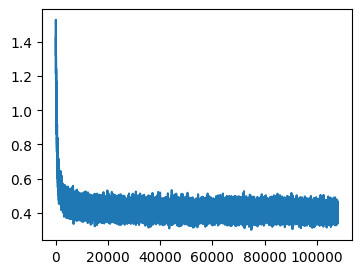

In [60]:
plt.figure(figsize=(4, 3))
plt.plot(loss_ls)
plt.show()

## Sample one

In [73]:
model_name = f'conditional_14_0.1_0.2_2e-06_5e-05_5'
model_file_path = f'score_model/model/{model_name}.pth'
Model = MLP_c
score_model_load = Model(n_node=num_nodes, amp=NN_amp).to(device)
model_statedict = torch.load(model_file_path, map_location=device)

score_model_load.load_state_dict(model_statedict)

scale = 1.5
sde = VPSDE(score_model_load, beta_min=beta_min_*scale, beta_max=beta_max_*scale)

In [ ]:
type_list = ['Langevin', 'euler', 'euler_ode']
s_type = type_list[2]

for target in range(3):
    c = torch.tensor([target], device=device).repeat(n_samples, 1)
    points = sde.sample(n_samples, num_steps, type=s_type, dim=2, w=0, c=c)


    if target==0:
        points_df = pd.DataFrame(points.squeeze(0).cpu().numpy(), columns=['x', 'y'])
        points_df['label'] = target
    else:
        points_df_ = pd.DataFrame(points.squeeze(0).cpu().numpy(), columns=['x', 'y'])
        points_df_['label'] = target
        points_df = pd.concat([points_df, points_df_], axis=0)

sns.lmplot(x='x', y='y', hue='label', data=points_df.groupby('label').head(5000), fit_reg=False, legend=True)
lim = 1.5
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)